In [1]:
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

SNAPSHOT_DATE = "4_Jan"

json_file = Path('prod_snapshot/schemes-prod-firestore-structure.json')
output_dir = Path(f'figures/{SNAPSHOT_DATE}')
os.makedirs(output_dir, exist_ok=True)

plt.rcParams['font.family'] = 'monospace'

### Data Extraction

In [11]:
with open(json_file, 'rb') as f:
    data = json.load(f)

    schemes = data['schemes']['documents']
    full_user_queries = data['userQuery']['documents']
    full_chat_history = data['chatHistory']['documents']

In [ ]:
# Filter user_queries and chat_history to only after update

query_ts_format_str = "%a, %d %b %Y %H:%M:%S %Z"
chat_ts_format_str = "%Y-%m-%d %H:%M:%S %Z"

def filter_new(user_queries: list[dict], chat_history: list[dict]) -> tuple[list[dict], list[dict]]:
    filtered_queries = []
    new, old, no_res = [], [], []
    for query in user_queries:
        x = query['data']['schemes_response']
        if (not x):
            no_res.append(query)
            continue

        ts_str = query['data']['query_timestamp']
        dt_object = datetime.strptime(ts_str, query_ts_format_str)

        if ('scheme' in x[0]):
            new.append(dt_object)
            filtered_queries.append(query)
        else: 
            old.append(dt_object)

    new.sort()
    old.sort()

    filtered_chat = []
    for chat_hist in chat_history:
        ts_str = chat_hist['data']['last_updated']
        if (datetime.strptime(ts_str, chat_ts_format_str) < old[-1]): continue

        filtered_chat.append(chat_hist)

    return filtered_queries, filtered_chat
        
user_queries, chat_history = filter_new(full_user_queries, full_chat_history)

In [13]:
user_queries[5]

{'id': '0155328a-caa8-11f0-8959-42004e494300',
 'data': {'query_timestamp': 'Wed, 26 Nov 2025 09:12:17 GMT',
  'session_id': '0155328a-caa8-11f0-8959-42004e494300',
  'query_text': 'Support for a family with 2 kids in Taman Jurong',
  'schemes_response': [{'last_llm_processed_update': {'_nanoseconds': 688000000,
     '_seconds': 1758367301},
    'service_area': 'No Service Boundaries',
    'how_to_apply': 'Application process is not specified in the provided text.',
    'what_it_gives': 'Financial assistance for daily living expenses, Food support',
    'vec_similarity_score': 1,
    'email': None,
    'scheme_id': 'fw9CubwfGkAcgqB5sVpB',
    'image': 'https://chidnast.sirv.com/SchemesSG/redcross.jpg',
    'scheme': 'Family LifeAid',
    'bm25_score': 0.24,
    'phone': None,
    'last_scraped_update': {'_nanoseconds': 341000000, '_seconds': 1758460196},
    'query': 'Support for a family with 2 kids in Taman Jurong',
    'planning_area': 'MUSEUM',
    'description': 'Identified househ

In [15]:
# Collecting data into Pandas DataFrames

from collections import Counter
from enum import Enum
import heapq

scheme_collator = []
# {
#     "dt": str,
#     "agency": str,
#     "scheme": str,
#     "id": str
# }

scheme_type_collator = []
# {
#     "dt": str,
#     "type": str
# }

query_type_collator = []
# {
#     "dt": str,
#     "type": str
# }

NUM_CATEGORIES_PER_QUERY = 2

vers_keys = [
    ('Scheme', 'Scheme Type', 'Agency', 'Similarity'),
    ('scheme', 'scheme_type', 'agency', 'Similarity'),
    ('scheme', 'scheme_type', 'agency', 'combined_scores')
]


for i, query in enumerate(user_queries):
    query_scheme_type = Counter()
    dt = datetime.strptime(query['data']['query_timestamp'], query_ts_format_str)

    if not (query['data']['schemes_response']): continue

    sample = query['data']['schemes_response'][0]
    if 'Scheme' in sample: keys = vers_keys[0]
    elif 'Similarity' in sample: keys = vers_keys[1]
    else: keys = vers_keys[2]

    scheme_name_key, scheme_type_key, scheme_agency_key, sim_key = keys

    for scheme in query['data']['schemes_response']:
        scheme_collator.append({
            "dt": dt,
            "agency": scheme[scheme_agency_key],
            "scheme": scheme[scheme_name_key],
            "id": scheme['scheme_id']
        })

        scheme_types = [x.lower().strip() for x in scheme[scheme_type_key].split(',')] if isinstance(scheme[scheme_type_key], str) else []
        for scheme_type_cat in scheme_types:
            scheme_type_collator.append({
                "dt": dt,
                "type": scheme_type_cat
            })

            query_scheme_type[scheme_type_cat] += scheme[sim_key]
    
    query_scheme_type_sorted = heapq.nlargest(NUM_CATEGORIES_PER_QUERY, query_scheme_type.items(), key=lambda x: x[1])
    for s_t, _ in query_scheme_type_sorted:
        query_type_collator.append({
            "dt": dt,
            "type": s_t, 
            "query": query['data']['query_text']
        })

scheme_df = pd.DataFrame(scheme_collator)
scheme_type_df = pd.DataFrame(scheme_type_collator)
query_type_df = pd.DataFrame(query_type_collator)

In [16]:
# For formatting labels (alignment, wrapping text)

def wrap_label(text: str, limit: int = 20, align_left: bool = True) -> str: 
    if len(text) < limit: return text
    
    words = text.split(' ')
    line_letter_count = 0
    max_line_letter_count = 0
    new_lines = []
    new_text_line = ''
    for word in words:
        if len(word) + line_letter_count < limit:
            new_text_line += word + ' '
            line_letter_count += len(word) + 1
            continue

        new_lines.append(new_text_line)
        max_line_letter_count = max(max_line_letter_count, line_letter_count)
        new_text_line = word + ' '
        line_letter_count = len(word) + 1

    new_lines.append(new_text_line)
    max_line_letter_count = max(max_line_letter_count, line_letter_count)

    if align_left:
        for i in range(len(new_lines)):
            new_lines[i] += (max_line_letter_count - len(new_lines[i])) * ' '
            
    return '\n'.join(new_lines)

## Search Data

### Recommended Schemes 

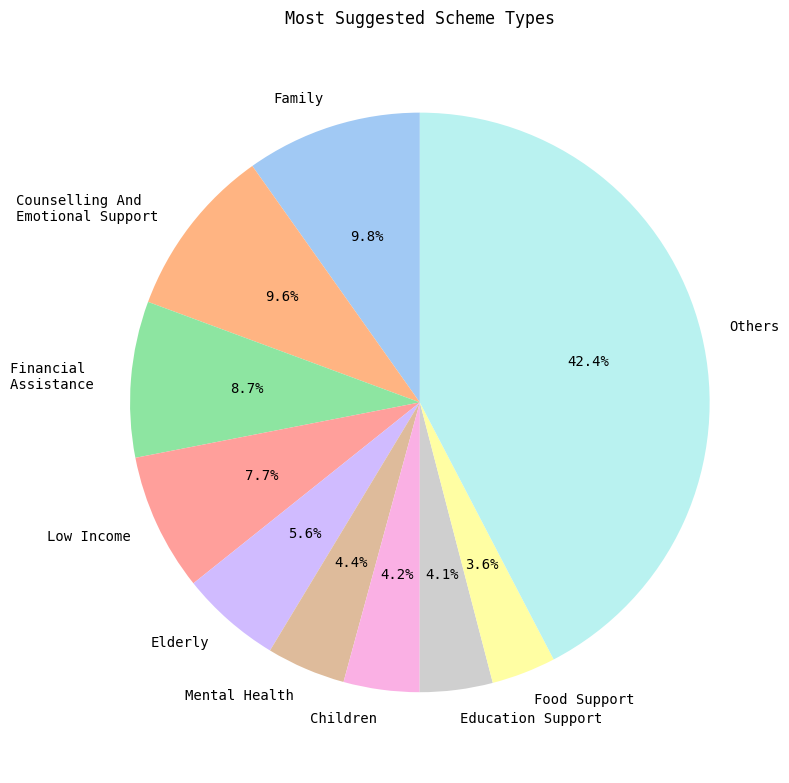

In [17]:
# Most commonly recommended scheme categories

TOP_N = 9

agg_df = scheme_type_df.groupby('type').size().reset_index(name='count').sort_values('count', ascending=False)

labels = agg_df['type'].head(TOP_N).to_list() + ['others']
sizes = agg_df['count'].head(TOP_N).to_list() + [agg_df.iloc[TOP_N:]['count'].sum()]

colors = sns.color_palette('pastel')

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=[wrap_label(label.title()) for label in labels], colors=colors, autopct='%1.1f%%', startangle=90)

plt.axis('equal')
plt.title('Most Suggested Scheme Types')
plt.tight_layout()

fig_fp = output_dir / 'types_piechart.jpg'
plt.savefig(fig_fp)
plt.show()

In [18]:
# Let's see what are some less common categories!
# Notice many of them overlap with the more common ones above

agg_df.tail(15)

,type,count
126,social activities,9
59,family support,9
15,casework and referral,8
104,need shelter,8
39,displaced families and individuals,8
86,indian community support,4
26,counseling,4
135,tcm,4
52,employment training,4
22,community engagement,3


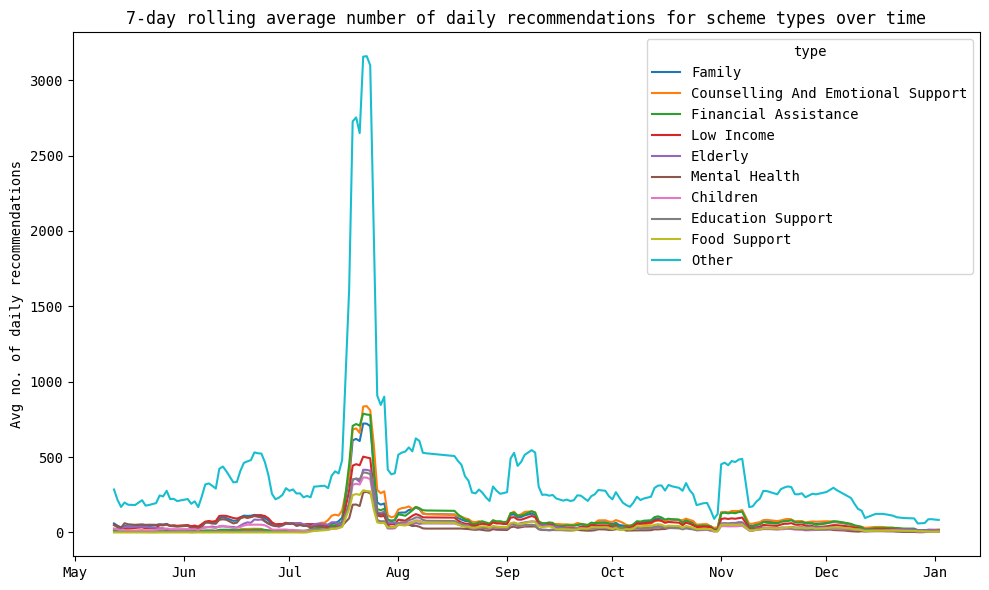

In [19]:
# Average number of daily recommendations of various scheme categories over time (7 day rolling average)

def make_rolling_df(df: pd.DataFrame, top_n: int, rolling_window: int =7) -> pd.DataFrame:
    grouped = df.groupby([df['dt'].dt.date, 'type']).size().reset_index(name='daily_count')
    grouped = grouped.rename(columns={'dt': 'date'})

    # Convert to wide format
    pivot_grouped = grouped.pivot(index='date', columns='type', values='daily_count').fillna(0)

    column_sums = pivot_grouped.sum().sort_values(ascending=False)
    top_categories = column_sums.head(top_n).index.tolist()

    condensed = pivot_grouped[top_categories].copy()
    other_categories = [col for col in pivot_grouped.columns if col not in top_categories]
    condensed['Other'] = pivot_grouped[other_categories].sum(axis=1)

    rolling = condensed.rolling(window=rolling_window, min_periods = 1).mean()

    # Convert back to long format for plotting
    rolling_long = rolling.reset_index().melt(id_vars='date', var_name='type', value_name='rolling')
    rolling_long['type'] = rolling_long['type'].str.title()

    return rolling_long

rolling_df = make_rolling_df(scheme_type_df, TOP_N)

plt.figure(figsize=(10, 6))

ax = sns.lineplot(data = rolling_df, x='date', y='rolling', hue='type', palette=sns.color_palette())

ax.set_title('7-day rolling average number of daily recommendations for scheme types over time')
ax.set_ylabel('Avg no. of daily recommendations')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()

fig_fp = output_dir / 'scheme_types_over_time.jpg'
plt.savefig(fig_fp)
plt.show()

### Queries

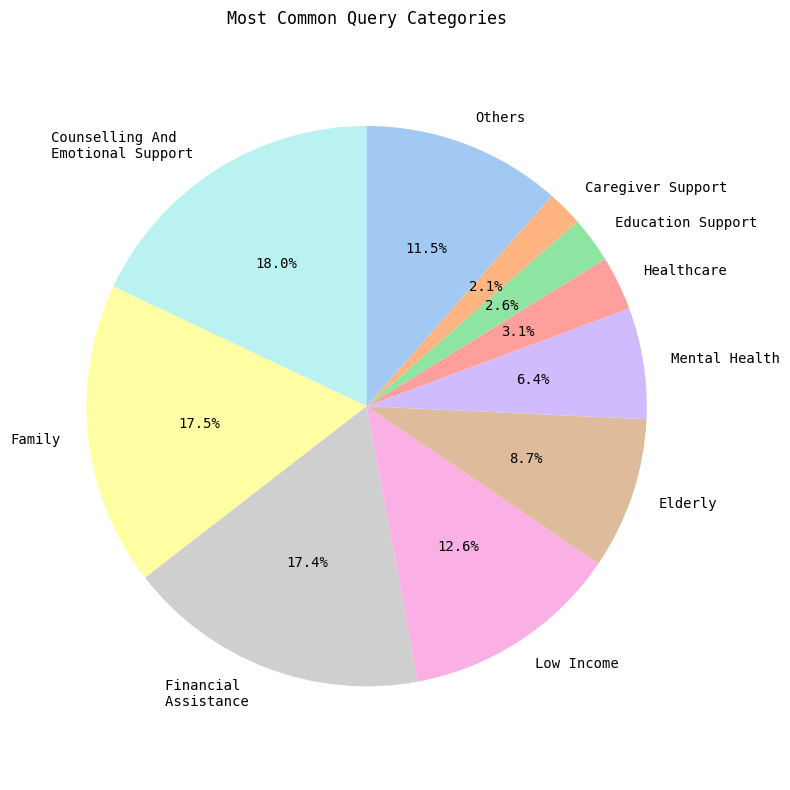

In [20]:
# Most common categories for queries (i.e. what are users asking), using scheme categories as proxy
# Proxy works by:
# 1. Collating all the categories of the recommended schemes for a query, 
# 2. Weighing them by the similarity score
# 3. Classify the query based on the categories which appear in the highest frequencies (how many can be determined by NUM_CATEGORIES_PER_QUERY)

TOP_N = 9

agg_df = query_type_df.groupby('type').size().reset_index(name='count').sort_values('count', ascending=False)

labels = agg_df['type'].head(TOP_N).to_list() + ['others']
sizes = agg_df['count'].head(TOP_N).to_list() + [agg_df.iloc[TOP_N:]['count'].sum()]

colors = sns.color_palette('pastel')[::-1]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=[wrap_label(label.title()) for label in labels], colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Most Common Query Categories')
plt.tight_layout()

fig_fp = output_dir / 'query_types_piechart2.jpg'
plt.savefig(fig_fp)
plt.show()

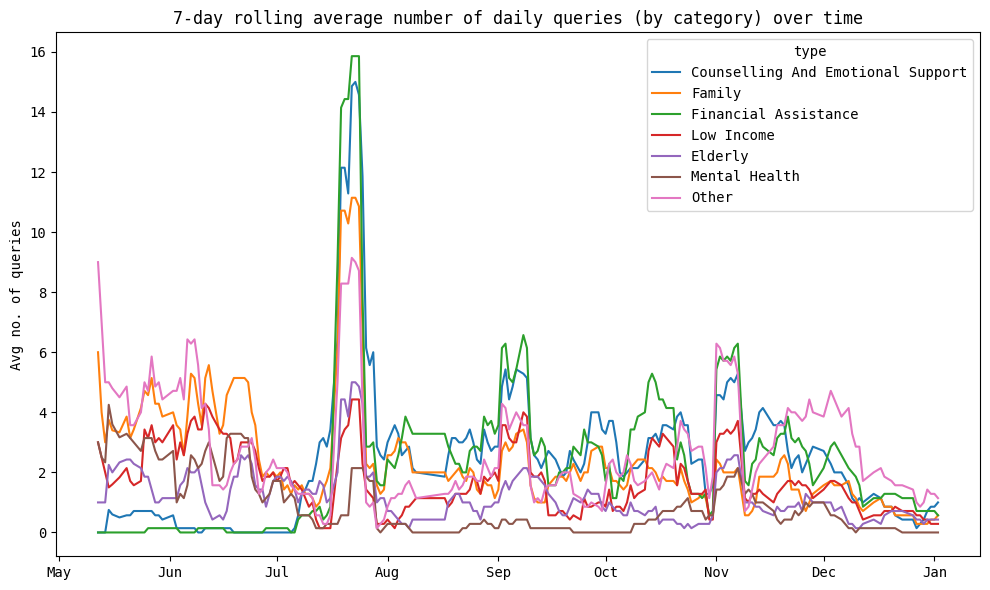

In [21]:
# Average number of daily queries (by category, same classifictaion methodology as above) over time (7 day rolling average)

rolling_df = make_rolling_df(query_type_df, 6, 7)

plt.figure(figsize=(10, 6))

ax = sns.lineplot(data = rolling_df, x='date', y='rolling', hue='type', palette=sns.color_palette()[:7])

ax.set_title('7-day rolling average number of daily queries (by category) over time')
ax.set_ylabel('Avg no. of queries')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()

fig_fp = output_dir / 'query_types_over_time.jpg'
plt.savefig(fig_fp)
plt.show()

In [22]:
# Save query dataFrame as csv
query_type_df.to_csv('query_classification.csv')

### Recommended Agencies

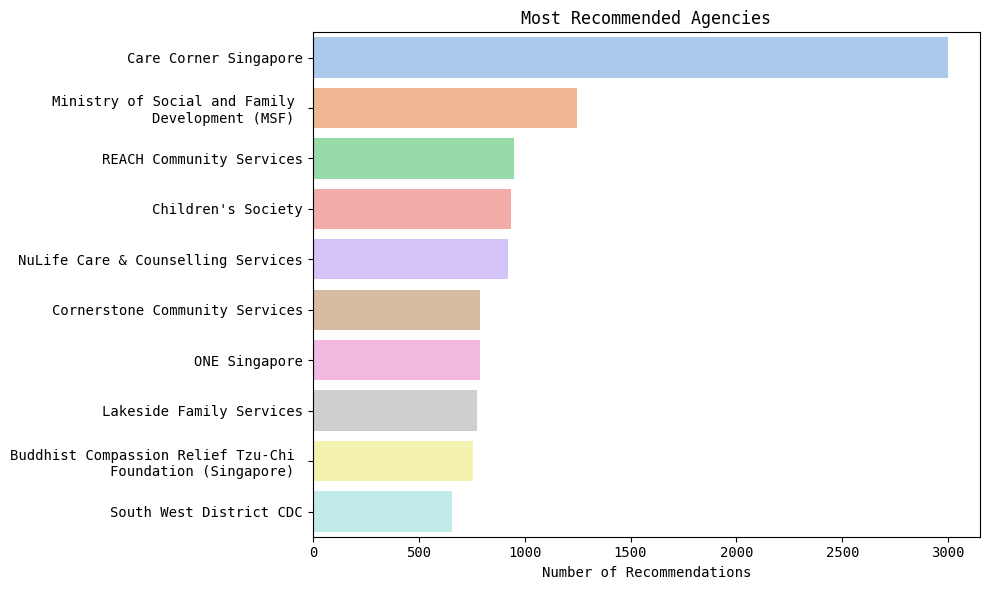

In [23]:
# Most recommended agencies

TOP_N = 10

top_n_df = scheme_df.groupby('agency').size().reset_index(name='count').sort_values('count', ascending=False).head(TOP_N)
top_n_df['agency'] = top_n_df['agency'].apply(wrap_label, args=(35, False))
barplot_data = {
    "Agencies": top_n_df['agency'].to_list(),
    "Recommendations": top_n_df['count'].to_list()
}

plt.figure(figsize=(10, 6))

ax = sns.barplot(y=barplot_data["Agencies"], x=barplot_data["Recommendations"], hue=barplot_data["Agencies"], orient='y', palette=sns.color_palette('pastel'))

ax.set_title('Most Recommended Agencies')
ax.set_xlabel('Number of Recommendations')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(
    ax.get_yticklabels(),
    ha='right',
    fontsize=10
)

plt.tight_layout()

fig_fp = output_dir / 'agencies.jpg'
plt.savefig(fig_fp)
plt.show()

### Recommedend Schemes

No. schemes with recommendations: 485
No. schemes without recommendations: -5
Total recommendations: 41921
Mean: 86.4	Median: 68


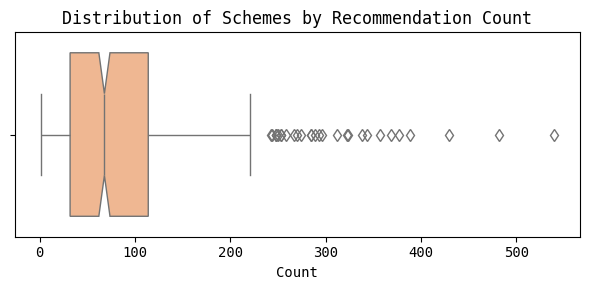

In [24]:
# Distribution of Schemes by number of recommendations (only works for post-update user_queries)

TOP_N = 10

scheme_count_df = scheme_df.groupby(['id']).size().reset_index(name='count').sort_values('count', ascending=False).reset_index(drop=True)

total_recs = scheme_count_df['count'].sum()

print(f"No. schemes with recommendations: {len(scheme_count_df['count'])}")
print(f"No. schemes without recommendations: {len(schemes) - len(scheme_count_df['count'])}")

print(f"Total recommendations: {scheme_count_df['count'].sum()}")
print(f"Mean: {round(scheme_count_df['count'].mean(), 1)}\tMedian: {round(scheme_count_df['count'].median())}")

plt.figure(figsize=(6, 3))
sns.boxplot(x=scheme_count_df['count'], color=sns.color_palette('pastel')[1], flierprops={"marker": "d"}, notch=True)

plt.xlabel('Count')
plt.title('Distribution of Schemes by Recommendation Count')
plt.tight_layout()

fig_fp = output_dir / 'scheme_recommendations.jpg'
plt.savefig(fig_fp)
plt.show()

In [33]:
# Display most commonly recommedended schemes

scheme_id_mapper = {}
for scheme in schemes:
    scheme_id_mapper[scheme['id']] = (scheme['data']['scheme'], scheme['data']['agency'])

error_count = 0

def retrieve_scheme(id: str) -> str:
    global error_count
    if id not in scheme_id_mapper: 
        error_count += 1
        return "" 
    return scheme_id_mapper[id][0]

def retrieve_agency(id: str) -> str:
    global error_count
    if id not in scheme_id_mapper: 
        error_count += 1
        return "" 
    return scheme_id_mapper[id][1]

scheme_count_df['scheme'] = scheme_count_df['id'].apply(retrieve_scheme)
scheme_count_df['agency'] = scheme_count_df['id'].apply(retrieve_agency)

print("Error count: ", error_count)
print("Most commonly recommended schemes:")
scheme_count_df[['scheme', 'agency', 'count']].head(TOP_N)

Error count:  12
Most commonly recommended schemes:


,scheme,agency,count
0,South West Caregiver Support Fund,South West District CDC,540
1,Compassion Fund,Compassion Fund Ltd,482
2,WeCare @ North East Fund,North East CDC,429
3,Financial Assistance Schemes & Food Vouchers,Eurasian Association Singapore,389
4,ComCare Interim Assistance,Ministry of Social and Family Development (MSF),377
5,Financial Asssistance,Children's Cancer Foundation,369
6,Living Assistance,Buddhist Compassion Relief Tzu-Chi Foundation ...,357
7,COVID-19 - Family Assistance Fund,Beyond Social Services,343
8,Children's Medical Fund,Children's Society,338
9,Family LifeAid,Red Cross Singapore,324


### Schemes Search Usage Rate

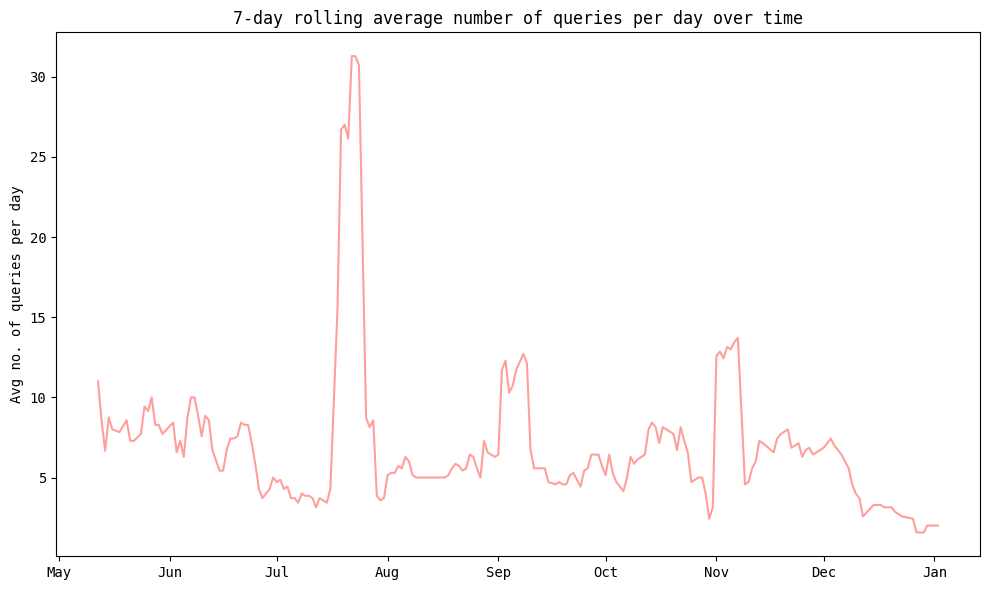

In [26]:
# No. of queries per day over time

dates = [datetime.strptime(query['data']['query_timestamp'], query_ts_format_str) for query in user_queries if query['data']['query_timestamp']]
dates_df = pd.DataFrame({'timestamps': dates})
grouped = dates_df.groupby(dates_df['timestamps'].dt.date).agg(count=('timestamps', 'count'))
grouped['rolling'] = grouped['count'].rolling(window=7, min_periods = 1).mean()
grouped['date'] = pd.to_datetime(grouped.index)

plt.figure(figsize=(10, 6))

ax = sns.lineplot(data = grouped, x='date', y='rolling', color=sns.color_palette('pastel')[3])

ax.set_title('7-day rolling average number of queries per day over time')
ax.set_ylabel('Avg no. of queries per day')
ax.set_xlabel('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.tight_layout()

fig_fp = output_dir / 'num_queries_over_time.jpg'
plt.savefig(fig_fp)
plt.show()

## Chat

### Usage

In [27]:
# Number of user queries and chat sessions

print(f"No. of User Queries:\t{len(user_queries)}")
print(f"No. of Chat Sessions:\t{len(chat_history)}")

No. of User Queries:	1402
No. of Chat Sessions:	702


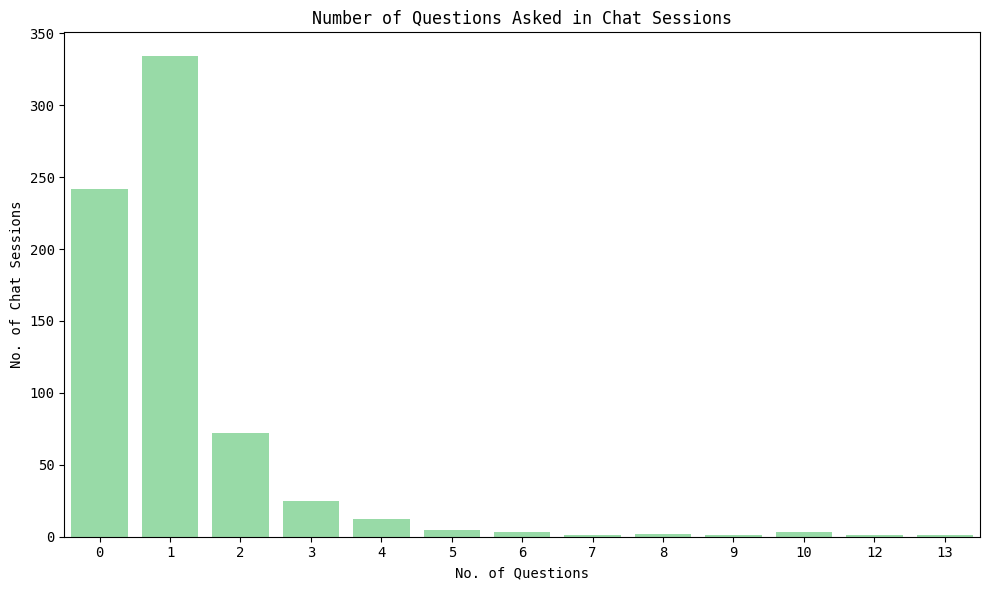

In [28]:
# Number of questions asked in Chat Sessions

num_messages = [len(chat_session['data']['messages']) for chat_session in chat_history]
num_questions = sorted([(num-1)//2 for num in num_messages])


plt.figure(figsize=(10, 6))

ax = sns.countplot(x=num_questions, color=sns.color_palette('pastel')[2])

ax.set_title('Number of Questions Asked in Chat Sessions')
ax.set_xlabel('No. of Questions')
ax.set_ylabel('No. of Chat Sessions')

plt.tight_layout()

fig_fp = output_dir / 'num_questions.jpg'
plt.savefig(fig_fp)
plt.show()

In [29]:
# For closer look into chat conversations with more questions

longer_conversations = [chat_session['data']['messages'] for chat_session in chat_history if (len(chat_session['data']['messages'])-1)/2 > 5]
with open('long_conv.json', 'w') as f:
    json.dump(longer_conversations, f, indent=4)

### Deeper Analysis of User Needs

In [42]:
# Code block below retrieves first question in each chat session and outputs them in a src.txt file

first_qns = []
for c in chat_history:
    msgs = c['data']['messages']

    if msgs[1]['role'] != 'user':
        raise Exception(f"2nd message not by user:{msgs}")
    first_qns.append(msgs[1]['content'].replace('\n', ' '))
    
qns_fp = Path('chat_questions') / 'src.txt'
with open(qns_fp, 'w') as f:
    f.write('\n'.join(first_qns))

`src.txt` was then uploaded to Gemini Notebook where Gemini assistant was told to sort the questions into 3 categories

1) Proper usage of Chat Assistant
2) Questions that should have been directed to Search Function
3) Irrelevant questions

Prompt

>Take a look at the source src.txt. Each line represents a new question asked by a user to the chat assistant. The intent of the chat assistant is to provide supplementary information and clarification of the suggested schemes, and not to act as a replacement of schemes search itself. Can you classify each of the questions asked in src.txt into 1 of the following 3 categories
>
>1) Proper usage of chat assistant - clarifications of certain scheme (e.g. what is comcare?), follow-ups (e.g. which is best/which can I, as a member of grp x, go for?), names of certain schemes (e.g. care corner) with the intention to ask chat assistant to elaborate
>
>2) Questions that should have been directed to Search Function - those of the form "I need x x x", or "I am x x x, and face y problems"
>
>3) Irrelevant messages (e.g. 'abc', 'hello')

Afterwards, the results were downloaded into the 3 respective files in the `chat_questions` folder: `chat.txt`, `search.txt` and `irrelevant.txt`

The results from Gemini Assistant was checked through and some entries were re-categorised.

In the end, it was concluded that out of ***307*** questions, only ***102*** of the messages (33%) were using chat for its intended purpose (to clarify schemes, provide more information on it), ***181*** messages (59%) appeared more suitable for the Search Function (they appeared more like search prompts) and ***24*** messages (8%) were irrelevant to SchemesSG. 

## User Profiling 

In [7]:
USER_PROFILES = {
    "Low-Income Individual or Family": ["income", "budget", "finances", "financials", "financial", "financially", "poor", "afford", "underprivileged"],
    "Parent or Family Member": ["parent", "parents", "mother", "mum", "father", "dad", "family member", "divorce", "divorced", "baby"],
    "Elderly (Senior)": ["elderly", "elders", "elder", "senior", "seniors", "old age", "ageing", "aging", "old folks"],
    "Person with Disabilities or Special Needs": ["pwd", "disabled", "disability", "disabilities", "handicapped", "special needs", "syndrome", "autism", "autistic", "bedridden", "bed ridden", "bed-ridden", "disorder"],
    "Caregiver": ["caregiver", "caregiving", "caring", "look after", "daytime support", "homebound", "bedridden"],
    "Child or Youth": ["teen", "teenage", "teenager", "youth", "youths", "student", "students", "orphan", "exam", "exams", "rebellious", "tuition", "underaged"],
    "Ex-Offender or Incarcerated Individual": ["offender", "offenders", "prison", "jail", "released"],
    "Migrant or Foreign Worker": ["migrant", "migrants", "foreign worker", "domestic worker", "maid", "helper", "transnational"],
    "Woman in Need of Support": ["woman", "single mother", "single mothers", "single mum", "single mums", "young mother", "young mothers", "young mum", "young mums", "widow", "female", "milk", "abortion", "pregnant", "pregnancy"],
    "Facing Mental Health Challenges": ["depression", "depressed", "depressive", "anxious", "anxiety", "anxieties", "mental", "therapy", "therapist", "lonely", "no friends", "no friend", "isolated", "suicidal", "suicide"],
    "Homeless or in Need of Shelter": ["homeless", "no home", "shelter", "rough sleeping", "evicted"],
    "Dealing with Addictions or Recovery": ["alcohol", "drinking", "gambling", "addiction", "addictions", "rehab", "rehabilitation", "drugs", "vaping", "vape", "kpod", "sex", "porn", "pornography", "gaming", "games"],
    "Facing End-of-Life or Terminal Illness": ["end of life", "terminal", "terminally ill", "palliative", "final stage", "advanced stage", "cancer", "dying"],
    "In Need of Legal Aid": ["legal", "lawyer", "court"],
    "Experiencing Abuse or Violence": ["abuse", "abused", "abusive", "violence", "violent", "sexual", "rape", "bullying", "bullied", "bullies", "bully", "harassment", "harassed"],
}

SCHEME_CATEGORIES = {
    "Financial Assistance Programs": ["financial", "financials", "financially", "finances", "finance", "earning", "earnings", "grant", "grants", "poor", "poverty", "cost", "costs", "fees", "subsidy", "subsidies", "money", "bills", "borrow", "pay", "paying", "payment", "savings", "rebates", "rebate", "grants", "grant", "loans", "loan", "debts", "debt", "comcare", "workfare", "bankrupt", "fines", "arrears", "vouchers", "voucher", "afford", "affordable", "budget", "budgeting", "chas", "scholarship", "scholarships", "bursary", "bursaries", "bonus", "bonuses", "payout", "payouts", "fund", "funds", "funding", "cdc", "cpf", "medisave", "medifund", "medishield", "silver support", "skillsfuture", "insurance", "expenses"],
    "Food Support": ["food", "meal", "meals", "groceries", "milk"],
    "Housing Assistance": ["housing", "house", "ownership", "evicted", "evict", "eviction", "rent", "rental", "flat", "hostel", "property", "landlord", "lease", "accommodation", "temporary housing", "hoard", "hoarding", "declutter", "decluttering", "hdb", "bto"],
    "Shelter Services": ["shelter", "shelters", "homeless", "rough sleeping", "rough sleeper"],
    "Healthcare Services": ["illness", "ill", "sick", "doctor", "nurse", "patient", "tcm", "hospital", "treatment", "healthcare", "medical", "medicine", "medication", "clinic", "appointment", "appointments", "health screening"],
    "Mental Health Support": ["therapy", "therapist", "mental", "depression", "depressed", "anxieties", "anxiety", "anxious", "suicidal", "suicide"],
    "Education Programs": ["school", "tuition", "education", "poly", "uni", "university", "academic"],
    "Employment Assistance": ["job", "jobs", "jobless", "work", "layoff", "skills", "upskill", "upskilling", "development", "part time", "employment", "career", "training", "retrenched", "retrenchment", "layoff", "fired", "unemployed", "workfare", "gig", "freelance"],
    "Caregiver Support": ["caregiver", "caregiving", "take care", "respite", "helper", "homebound", "bedridden"],
    "Transport Services": ["transport", "bus", "fare", "shuttle", "get around"],
    "Legal Aid Services": ["legal", "lawyer", "court", "sue"],
    "Addiction Recovery Services": ["alcohol", "drinking", "drug", "drugs", "addiction", "rehab", "kpod", "halfway"],
    "Family Support Services": ["family support", "family service", "childcare", "child care", "daycare", "home care", "orphanage", "custody", "divorce", "divorced", "marriage", "married", "nursing", "elder care", "eldercare", "old aged home", "old folks home", "dementia", "adoption", "foster", "fostering", "parenting", "baby", "active ageing", "active aging"],
    "Disability Support Services": ["disability", "special needs", "wheelchair"],
    "Palliative Care Services": ["end of life", "terminal", "terminally ill", "final stage", "advanced stage", "palliative", "hospice", "cancer", "dying"],
    "Social Work & Casework": ["social worker", "social work", "counselling", "counsellor", "behavioural", "risk", "anger", "abuse", "harrassment", "violence", "sexual", "rape", "boys home", "girls home", "emotional", "emotions", "talk to", "trauma", "mediate", "mediation", "psychologist", "therapist", "therapy", "relationships", "relationship"],
}

In [ ]:
# Data for user profile barplot

profile_details = []
for cat, phrases in USER_PROFILES.items():
    profile_details.append([phrases, cat, 0, []])

unclassified = 0

for query in full_user_queries:
    query_text = query['data']['query_text'].lower()
    classified = False 
    for det in profile_details:
        for phrase in det[0]:
            if phrase in query_text: 
                classified = True
                det[2] += 1
                det[3].append(query["id"])
                break

    if not classified: unclassified += 1

print("Total:", len(full_user_queries))
print("Unclassified:", unclassified)
profile_counts = sorted([(cat, count) for _, cat, count, _ in profile_details], key = lambda x: x[1], reverse=True)
for cat, count in profile_counts:
    print(f"{cat}: {count}")

Total: 2492
Unclassified: 645
Low-Income Individual or Family: 713
Facing Mental Health Challenges: 264
Parent or Family Member: 243
Elderly (Senior): 238
Child or Youth: 237
Caregiver: 205
Woman in Need of Support: 162
Person with Disabilities or Special Needs: 133
Homeless or in Need of Shelter: 118
Facing End-of-Life or Terminal Illness: 115
Dealing with Addictions or Recovery: 91
Ex-Offender or Incarcerated Individual: 86
In Need of Legal Aid: 69
Experiencing Abuse or Violence: 50
Migrant or Foreign Worker: 35


In [34]:
# Data for scheme categories barplot

schemes_details = []
for cat, phrases in SCHEME_CATEGORIES.items():
    schemes_details.append([phrases, cat, 0, []])

unclassified = 0
scheme_category_by_id = {}

for scheme in schemes:
    text = scheme['data']['scheme_type'].lower()
    classified = False 

    temp = []
    scheme_category_by_id[scheme["id"]] = temp

    for det in schemes_details:
        for phrase in det[0]:
            if phrase in text: 
                classified = True
                det[2] += 1
                det[3].append(scheme["id"])
                temp.append(det[1])
                break

    if not classified: 
        unclassified += 1

print("Total:", len(schemes))
print("Unclassified:", unclassified)
schemes_count = sorted([(cat, count) for _, cat, count, _ in schemes_details], key = lambda x: x[1], reverse=True)
for cat, count in schemes_count:
    print(f"{cat}: {count}")

Total: 480
Unclassified: 10
Social Work & Casework: 247
Financial Assistance Programs: 187
Education Programs: 125
Caregiver Support: 87
Mental Health Support: 79
Healthcare Services: 77
Employment Assistance: 70
Housing Assistance: 59
Transport Services: 48
Palliative Care Services: 46
Food Support: 45
Shelter Services: 44
Addiction Recovery Services: 42
Disability Support Services: 22
Legal Aid Services: 21
Family Support Services: 20


In [ ]:
# Data for co-occurence plot

